# Optimizacion con MAPL + DicsBvals

In [69]:
%pylab inline
import time
import numpy as np
import matplotlib.pyplot as plt
from utils import img_utils
import seaborn as sns
import utils.math_utils as mat_utils
#import nibabel as nib
import mapmri.mapmri as mp
#from dipy.core.gradients import gradient_table
import cvxpy as cvx
reload(img_utils)
import load.hcp_img_loader as hcp

Populating the interactive namespace from numpy and matplotlib


In [51]:
def get_sample(index, numbers, loader_func, bval=None, bvalpos=None,  scale=2):
    img, gtab = loader_func(index, numbers, bval, bvalpos)
    lr, lr_affine = img_utils.downsampling(img, scale)
    return img.get_data(), lr

def get_sample_maker(numbers, loader_func, bval=None, bvalpos=None, scale=2):
    return lambda index : get_sample(index, numbers, loader_func, bval, bvalpos,  scale)

def mm(A, cast_int=True):
    if cast_int :
        return (int(A.min()), int(A.max()))
    else:
        return (A.min(), A.max())
    
def buildT(sample_getter, n_samples):
    noised_hr, noised_lr = sample_getter(0)
    X = img_utils.column_this(noised_lr)
    Y = img_utils.column_this(noised_hr)
    for i in range(1, n_samples):
        noised_hr, noised_lr = sample_getter(i)
        X = img_utils.append_column(X, noised_lr)
        Y = img_utils.append_column(Y, noised_hr)
    return X, Y

def buildT_grouping_by_q(sample_getter, n_samples, bvals):
    """
    Genera tantos conjuntos de entrenamiento como 
    bvals distintos tenga el volumne
    """
    hr, lr = sample_getter(0)
    bs = bvals[0:hr.shape[3]]
    #dicIndices = dict((b , [ i for i in xrange(len(bs)) if bs[i] == b] ) for b in bs)
    #dicIndices = dict((i , [ i for i in xrange(len(bs)) if bs[i] == b] ) for b in bs)
    
    dicX = split_by_bval(lr, bs)
    dicY = split_by_bval(hr, bs)
    for i in range(1, n_samples):
        hr, lr = sample_getter(i)
        dicX = split_by_bval(lr, bs, dicX)
        dicY = split_by_bval(hr, bs, dicY)
    return dicX, dicY

def split_by_bval(img, bvals, res=None):
    """
    Dada una imagen separa la cuarta dimension segun su vbal
    Y por cada una hace un vector columna
    """
    if res is None:
        res = dict((i, None) for i in xrange(len(bvals)))
        
    for b in xrange(len(bvals)):
        XorY = res[b]
        if XorY is None:
            res[b] = img_utils.column_this(img[:,:,:,b])
        else:
            res[b] = img_utils.append_column(XorY, img[:,:,:,b])
    return res

    

## Example of use
#buildT(get_sample_maker(numbers, scale), n_samples)

## Problem definition


$ \min_{Y^{hr},C} \{ (\sum_{b\in bvals} ||G_{b}Y_{b}^{hr} - Y_{b}^{lr}||^2) + || Y^{lr} - S_0*\phi*C||^2 + ||C||_{1} \}$


## MapMri

In [103]:
def getM(radial_order, mu, gtab, tau):
    r'''Recovers the reconstructed signal for any qvalue array or
        gradient table.
        '''
    qvals = np.sqrt(gtab.bvals / tau) / (2 * np.pi)
    q = qvals[:, None] * gtab.bvecs
    M = mp.mapmri_isotropic_phi_matrix(radial_order, mu[0], q)
    return  M

def get_mapl_params(gtab, radial_order = 4):
    #Fiteo el model
    map_model = mp.MapmriModel(gtab,
                                radial_order=radial_order,
                                laplacian_regularization=True,
                                laplacian_weighting=0.2,
                                anisotropic_scaling=False,
                                dti_scale_estimation=False)
    # Fiteo la data
    #map_model_fit = map_model.fit(i_hr)
    tau = map_model.tau
    mu = map_model.mu
    print 'mu.shape', mu.shape
    M = getM(radial_order, mu, gtab, tau)
    return M, tau, mu

def mapl_predict(gtab, C_or_Cvec, M, tau, Nx=None, Ny=None, Nz=None):
    """
       This method can be used to predit a given q-points (within gtab)
       For a previous fited C or a cvxpy dual variable definition
    """
    is_cvxpy = isinstance(C_or_Cvec, cvx.Variable)
    print 'M.shape', M.shape, 'C.size', C_or_Cvec.size
    Nb, Nc = M.shape
    vhr, Nc = C_or_Cvec.shape if hasattr(C_or_Cvec, 'shape') else C_or_Cvec.size
    #vhr = Nx*Ny*Nz
    
    Cvec = C_or_Cvec
    if not is_cvxpy :
        Cvec = C.reshape((vhr, Nc), order='F')
         
    if is_cvxpy :
        E = (M * Cvec.T)
    else:
        E = np.dot(M, Cvec.T).T
        
    if not is_cvxpy :
        print E.shape,(Nx, Ny, Nz, Nb) 
        E = E.reshape((Nx, Ny, Nz, Nb), order='F')
    #else:
    #    E = E.reshape(-1, order='F')
        
    return E


def cvxpy_mapl(Yhr, gtab, M, tau, Nc):
    Nx, Ny, Nz, bval = i_hr.shape
    vhr = Nx*Ny*Nz
    vhrb = vhr*bval
    
    # Image to fit
    cvxC = cvx.Variable(vhr, Nc)

    cvxMaplE = mapl_predict(gtab, cvxC, M, tau)
    #print 'E.size', cvxE.size

    # Hr image in row by b-val
    YhrMapl = cvx.reshape(Yhr, vhr,bval).T
    
    ## objective
    #obj = cvx.Minimize(cvx.sum_squares(cvxE-YhrMap) + alpha*cvx.norm1(cvxC))

    return cvxMaplE, cvxC, YhrMapl
    ## some constraints
    # pos_cons =[ cvxM*cvxC[i,:].T >= 0  for i in xrange(vhr) ]
    # max_cons =[ cvxM*cvxC[i,:].T*cvxS0[i] <= i_hr.max() for i in xrange(vhr) ]

In [60]:
def define_problem_with_mapl(i_lr, i_hr_shape, dic_G, M, tau, gtab, scale):
    Nx, Ny, Nz, bval = i_hr_shape
    _, Nc = M.shape
    vlr = Nx*Ny*Nz/(scale**3)
    vlrb = vlr*bval
    vhr = Nx*Ny*Nz
    vhrb = vhr*bval
      
    ## Hr volumes
    Yhr = cvx.Variable(vhrb, 1)
    Yhr.value = np.ones((vhrb, 1))*i_lr.mean()
    
    ## LR volumes
    Ylr = cvx.Parameter(vlr*bval, 1, sign="positive")
    Ylr.value = i_lr.reshape((vlr*bval, 1), order='F')
    
    ## Downsamplings matrixs
    G = dict((group, cvx.Parameter(*dic_G[group].shape)) for group in dic_G.keys())
    for group in dic_G.keys():
        G[group].value = dic_G[group]
    
    ## MAPL params
    cvxMaplE, cvxC, YhrMapl = cvxpy_mapl(Yhr, gtab, M, tau, Nc)
    
    ## Mapl dual expression
    cvxMaplDualExp = cvx.sum_squares(cvxMaplE-YhrMapl)
    
    ## Mapl weight
    betha = cvx.Parameter(value=.23, sign='positive')
    ## Sparcity weight
    alpha = cvx.Parameter(value=.15, sign='positive')
    ## Fidelity weight
    gamma = cvx.Parameter(value=.62, sign='positive')
    
    #epsilon = cvx.Parameter(value=1, sign='positive')
    #constraints = [cvxMaplDualExp <= epsilon]
    
    ## Fidelity expression
    fidelity_list = []
    for b in xrange(bval):
        b_offset_hr, b_offset_lr = b*vhr, b*vlr
        Yhr_b = Yhr[b_offset_hr:b_offset_hr+vhr]
        Ylr_b = Ylr[b_offset_lr:b_offset_lr+vlr]
        fid_b = cvx.sum_squares(G[b]*Yhr_b - Ylr_b)
        fidelity_list.append(fid_b)
    print '#fidelity sums =', len(fidelity_list)
    cvxFidelityExp = sum(fidelity_list)
    
    # Form objective.
    obj = cvx.Minimize(gamma*cvxFidelityExp + betha*cvxMaplDualExp + alpha*cvx.norm1(cvxC))
    #obj = cvx.Minimize(cvxFidelityExp )

    # Constraints
    # constraints = [Yhr >= 0, mapl <= epsilon*vhr*bval]
    constraints = []
    
    # Form and solve problem.
    prob = cvx.Problem(obj, constraints)
    
    return prob, Yhr, Ylr, cvxC, G 

"""
NOTAS:
 - la primera formulacion funciono bastante bien (con la sum de los sum_squears) fue 
   sacado el metodo para preservarlo
 - probe con la lista de constraints de mapl con igualdad dio todos infeasibles
   (proximo a probar lo mismo con desigualdad a un epsilon en vez de igualdad)
 - 
   
"""
print

In [42]:
def solveMin(i_lr, i_hr_shape, dic_G, M, tau, gtab, scale=2, max_iters=1500, verbose=False):
    Nx, Ny, Nz, Nb = i_hr_shape
    Nb, Nc = M.shape
    prob, Yhr, Ylr, cvxC, G = define_problem_with_mapl(
                                i_lr, 
                                i_hr_shape, 
                                dic_G, 
                                M, tau,
                                gtab,
                                scale)
     
    start_time = time.time()
    res = prob.solve(solver='SCS', max_iters=max_iters, eps=1.00e-01, verbose=verbose )  # Returns the optimal value.
    seg = time.time() - start_time

    minutes = int(seg / 60)
    print("--- time of optimization : %d' %d'' ---" % (minutes , seg%60))
    print "--- status:", prob.status, "optimal value", prob.value
    print 

    # Change dimension of result representation
    C, A = None, None
    if Yhr.value is None :
        #Yhr.value = np.ones(i_hr_shape)
        print 'FRECONSTRUCTION FAIL :('
        A = np.zeros(i_hr_shape,dtype='float32')
    else:    
        A = np.asarray(Yhr.value, dtype='float32').reshape(i_hr_shape, order='F')
        C = np.asarray(cvxC.value, dtype='float32').reshape((Nx, Ny, Nz, Nc), order='F')
 
        
    return A, C, seg, prob


## Solving the problem and cross-validation (leave one out)

In [56]:
from scipy.sparse import csr_matrix
import experimento1_funciones as e1f
reload(e1f)

RES_BASE_FOLDER = './resultados/exp5/'
VMIN, VMAX=-50, 2500

voi_hr_shape = (12, 12, 12, 6)
voi_lr_shape = (6, 6, 6, 6)
subjects = [100307, 100408, 180129, 180432, 180836, 180937]
bvals2000pos = [18, 27, 69, 75, 101, 107]

# Esto es por si quiero alguna S0
#img_s0, gtab_s0 = load_subject_small(0, subjects, bval=5, bvalpos=bvals5pos[0:6])
#i_hr=img.get_data()
#S0 = img_s0.get_data()

# Esto es para quedame con la gtab que es igua a todos
#img, gtab = hcp.load_subject_small(0 , subjects)
img, gtab = hcp.load_subject_small(0, subjects, bval=2000, bvalpos=bvals2000pos)
del img

## Con imagenes pequenas multi-shel
#sample_maker = get_sample_maker(subjects, hcp.load_subject_small, scale=2)
## Con imagenes pequenas single-shel
loader_func = hcp.load_subject_small
sample_maker = get_sample_maker(subjects, loader_func, scale=2)


n_samples = 3
iterations = 1

# Metrics to save
min_vals_hr_r = []
max_vals_hr_r = []
min_vals_lr_r = []
max_vals_lr_r = []

dif_norm_hrs=[]
dif_norm_lrs=[]    
Yhr_recons_norms=[]
Ylr_recons_norms=[]  
Yhr_norms=[]
Ylr_norms=[]
times = []
optimal_vals = []

## For save results
# base_folder = RES_BASE_FOLDER
## For NOT save results
base_folder = None

for i in range(0, iterations):
    subject = str(subjects[len(subjects)-1])
    print '== Leaving out: #', subject
    
    ### Aca shiftear el arreglo de sujetos (train deja el ultimo afuera del entrenamiento)
    subjects.append(subjects.pop(0))
    lr_samples, hr_samples = buildT_grouping_by_q(sample_maker, n_samples, gtab.bvals) #lr, hr

    #lr_samples, hr_samples = lr_samples/1589, hr_samples/1589
    #print 'SAMPLES min/max ', lr_samples.min(),lr_samples.max(),  hr_samples.min(), hr_samples.max()
    
    # Build downsampling matrix
    print '= Training and fiting ...'
    regr, hr_train , lr_train, hr_test, lr_test = e1f.train_grouping_by_b(hr_samples, lr_samples)
    G = dict((b,csr_matrix(regr[b].coef_)) for b in regr.keys())
    #regr.coef_ = csr_matrix(regr.coef_)
    
    # Reshape the one that left out to validate
    the_one_out = len(subjects)-1
    i_hr, i_lr = get_sample(the_one_out, subjects, loader_func, scale=2)
    #i_lr = lr_test.reshape(voi_lr_shape, order='F')
    #i_hr = hr_test.reshape(voi_hr_shape, order='F')
    
    # Mapl params
    M, tau, mu = get_mapl_params(gtab, radial_order = 4)
    
    # Minimization solve
    # mock: A, seg = np.ones(i_hr.shape), 20
    print '= Solving optimization problem ...'
    A, C, seg, prob = solveMin(i_lr, i_hr.shape, G, M, tau, gtab, scale=2, max_iters=1500, verbose=True)
    max_vals_hr_r.append(A.max())
    min_vals_hr_r.append(A.min())
    
    nx, ny, nz, nb = i_lr.shape
    B = np.zeros((nx, ny, nz, nb))
    for b in xrange(nb):
        B[:,:,:,b] = (G[b]*i_hr[:,:,:,b].reshape(-1, order='F')).reshape((nx, ny, nz), order='F')
    max_vals_lr_r.append(B.max())
    min_vals_lr_r.append(B.min())
    
    # Keep parameters
    print '= Calculating metrics...'
    dif_norm_hr = np.linalg.norm(i_hr-A) # recons-gtrust
    Yhr_norm = np.linalg.norm(i_hr)
    Yhr_recons_norm = np.linalg.norm(A) #recons
    
    dif_norm_lr = np.linalg.norm(i_lr-B)
    Ylr_norm = np.linalg.norm(B)
    Ylr_recons_norm = np.linalg.norm(B)
    
    dif_norm_hrs.append(dif_norm_hr)
    dif_norm_lrs.append(dif_norm_lr)
    
    Yhr_recons_norms.append(Yhr_recons_norm)
    Ylr_recons_norms.append(Ylr_recons_norm)
    
    Yhr_norms.append(Yhr_norm)
    Ylr_norms.append(Ylr_norm)
    
    times.append(seg)
    optimal_vals.append(prob.value)

    # Save the A calculated
    if base_folder is not None:
        name = base_folder+ "A/" + 'hrRec_lo' + subject
        np.save(name, A)
        print 'showing hr '+ subject, 'min, max',(A.min(), A.max()) 
        titles=['Reconstruida', 'Original']
        for b in xrange(6):
            plt = img_utils._isc(A, i_hr,b=b ,titles=titles,  vmax=VMAX, vmin=VMIN)
            plt.savefig(name +'b'+str(b)+'.pdf')
        print 'saved A in: ', name + str('.npy')
        
    # Save the B calculated
    if base_folder is not None:
        name = base_folder + 'lrRec_lo' + subject
        np.save(name, B)
        print 'showing lr '+ subject, 'min, max',(B.min(), B.max()) 
        titles=['Reconstruida', 'Original']
        plt = img_utils._isc(B, i_lr, titles=titles,  vmax=VMAX, vmin=VMIN)
        plt.savefig(name + '.pdf')
        print 'saved A in: ', name + str('.npy')
        
    print
    print

# Log spended
total_sec = np.array(times).sum()
print ' === TOTAL TIME :',  str(int(total_sec//60))+"'", str(int(total_sec%60))+ '"'

# Persist results
if base_folder is not None: 
    np.save(base_folder+ 'dif_norm_hrs', dif_norm_hrs)
    np.save(base_folder+ 'dif_norm_lrs', dif_norm_lrs)
    np.save(base_folder+ 'Yhr_recons_norms', Yhr_recons_norms)
    np.save(base_folder+ 'Ylr_recons_norms', dif_norm_hrs)
    np.save(base_folder+ 'Yhr_norms', dif_norm_lrs)
    np.save(base_folder+ 'Ylr_norms', Yhr_recons_norms)
    
    np.save(base_folder+ 'max_vals_hr_r', max_vals_hr_r)
    np.save(base_folder+ 'min_vals_hr_r', min_vals_hr_r)
    np.save(base_folder+ 'max_vals_lr_r', max_vals_hr_r)
    np.save(base_folder+ 'min_vals_lr_r', min_vals_hr_r)
    
    np.save(base_folder+ 'times' , times)
    np.save(base_folder+ 'optimal_vals', optimal_vals)


== Leaving out: # 180937
= Training and fiting ...
mu.shape (3,)
= Solving optimization problem ...
M.shape (6, 22) C.size (1728, 22)
----------------------------------------------------------------------------
	SCS v1.2.6 - Splitting Conic Solver
	(c) Brendan O'Donoghue, Stanford University, 2012-2016
----------------------------------------------------------------------------
Lin-sys: sparse-indirect, nnz in A = 2630030, CG tol ~ 1/iter^(2.00)
eps = 1.00e-01, alpha = 1.50, max_iters = 1500, normalize = 1, scale = 1.00
Variables n = 86407, constraints m = 87710
Cones:	linear vars: 76032
	soc vars: 11678, soc blks: 7
Setup time: 9.12e-02s
----------------------------------------------------------------------------
 Iter | pri res | dua res | rel gap | pri obj | dua obj | kap/tau | time (s)
----------------------------------------------------------------------------
     0|      inf       inf      -nan      -inf       inf       inf  3.12e-01 
    20| 5.20e-02  3.61e-02  1.95e-02  2.27e+

<module 'matplotlib.pyplot' from '/user/lgomez/home/anaconda2/lib/python2.7/site-packages/matplotlib/pyplot.pyc'>

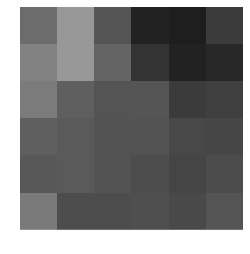

In [61]:
img_utils._is(B, b=0, vmax=B.max(), vmin=B.min())

recons (-8040.127, 1143.3719, 28406.824)
orig (0.0, 1515.9221, 13620.414)
con la primer forma de tvnorm
dif_norm_hrs [268950.41]
dif_norm_lrs [46087.348802070519]
Yhr_recons_norms [279723.12]
Ylr_recons_norms [75886.936960385588]
Yhr_norms [252462.7]
Ylr_norms [75886.936960385588]
times [4.238785982131958]
optimal_vals [2267070.812859458]


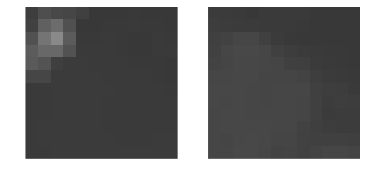

In [58]:
img_utils._isc(A, i_hr, b=4, vmax=max(i_hr.max(), A.max()), vmin=min(i_hr.min(),A.min()))

#img_utils._is(A, vmin=A.min(), vmax=A.max())
print 'recons', (A.min(), A.mean(), A.max())
print 'orig',(i_hr.min(), i_hr.mean(), i_hr.max())
#G.shape

print 'con la primer forma de tvnorm'
print 'dif_norm_hrs', dif_norm_hrs
print 'dif_norm_lrs', dif_norm_lrs   
print 'Yhr_recons_norms', Yhr_recons_norms
print 'Ylr_recons_norms', Ylr_recons_norms
print 'Yhr_norms', Yhr_norms
print 'Ylr_norms', Ylr_norms
print 'times',times
print 'optimal_vals', optimal_vals

<module 'matplotlib.pyplot' from '/user/lgomez/home/anaconda2/lib/python2.7/site-packages/matplotlib/pyplot.pyc'>

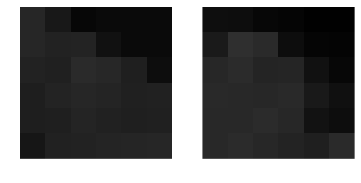

In [62]:
img_utils._isc(B, i_lr, b=4, vmax=max(i_lr.max(), B.max()), vmin=min(i_lr.min(),B.min()))


# HR Testing reconstruction 


(12, 12, 12)


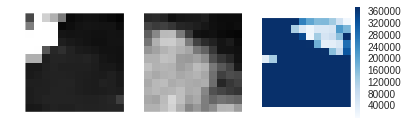

In [59]:
mse = ((A-i_hr)**2).mean(axis=3)
print mse.shape

reload(img_utils)
plt, _, _, im3 = img_utils._isc3(A, i_hr, mse,  b=4, vmax=[3000,374942], vmin=[0, 300])
plt.colorbar(im3,fraction=0.056, pad=0.04)

# LR Testing reconstruction

$ G*Yhr = Yhr^* $

In [110]:
def errrel_layers(A, B):
    err_rel = np.zeros(A.shape)
    for b in xrange(A.shape[3]):
        err_rel[:,:,:,b] = np.divide(np.abs(A[:,:,:,b]-B[:,:,:,b]), B[:,:,:,b]+0.01)
    return err_rel
    

(6, 6, 6, 6) mse: (0, 22) 0.606745266942 1.49415870256 B: (129, 11659) i_lr: (73, 12425)


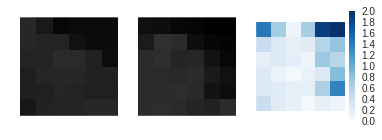

In [111]:
mse_lr = errrel_layers(B,i_lr)
#mse_lr = ((mat_utils.normalize(B)-mat_utils.normalize(i_lr))**2).mean(axis=3)
#mse_lr = ((np.divide(B-i_lr, i_lr))**2).mean(axis=3)
print mse_lr.shape, 'mse:',mm(mse_lr), mse_lr.mean(), np.std(mse_lr), 'B:',mm(B),'i_lr:', mm(i_lr)

reload(img_utils)
plt, _, _, im3 = img_utils._isc3(B, i_lr, mse_lr,  b=4, vmin=[73, 0], vmax=[12000,2],)
plt.colorbar(im3,fraction=0.056, pad=0.04)

# Testing Mapl reconstruction

M.shape (6, 22) C.size 38016
(1728, 6) (12, 12, 12, 6)
(0, 21230)
Error relativo max,min u std (0, 38) 1 1


'\nMAPL SALE PAL TRASTE PORQ \n'

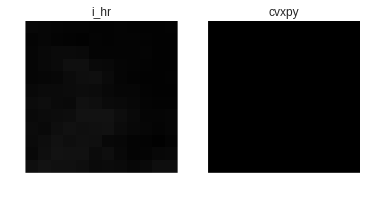

In [118]:
Nx, Ny, Nz, Nb = i_hr.shape
Nb, Nc =  M.shape
Eq_reconst = mapl_predict(gtab, C.reshape((Nx*Ny*Nz, Nc), order='F'), M, tau, Nx, Ny, Nz)


err = np.abs(Eq_reconst - i_hr)
err_rel = np.divide(err, i_hr+1)#para q no de infinito

print mm(err) 
print 'Error relativo max,min u std', mm(err_rel), int(err_rel.mean()), \
                                      int(np.std(err_rel)) 

#img_utils._isc(i_hr, Eq_reconst,b=b, vmin=0, vmax=i_hr.max(), titles=['i_hr', 'cvxpy'])
img_utils._isc( mat_utils.normalize(i_hr), mat_utils.normalize(Eq_reconst),b=b, vmin=0, vmax=1, titles=['i_hr', 'cvxpy'])
mm(i_hr), mm(Eq_reconst)

"""
MAPL SALE PAL TRASTE PORQ 
precisa mas de 6 puntos 
- probar con menos orden 
- probar con minimo 40 puntos y q dios ayude a la compu!!!

"""
